# VGG

## Import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

## VGG block

In [2]:
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    x = input_layer

    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [3]:
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## VGG-16

In [4]:
vgg_16 = build_vgg()
vgg_16.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)        

## VGG-19

In [5]:
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)
vgg_19.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)        

## Dataset (CIFAR-10)

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [7]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [8]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [9]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_info.features["label"].num_classes

10

In [12]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

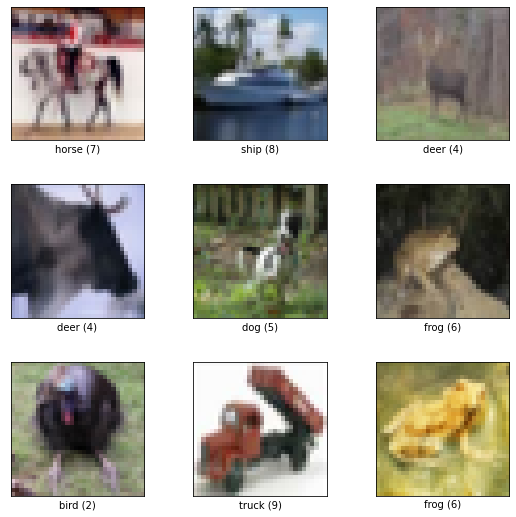

In [13]:
fig = tfds.show_examples(ds_train, ds_info)

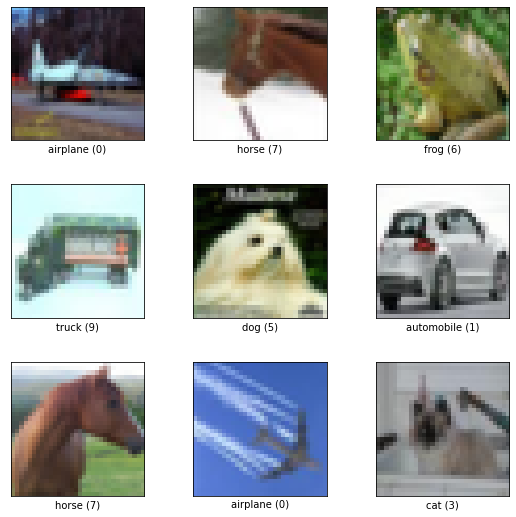

In [14]:
fig = tfds.show_examples(ds_test, ds_info)

## VGG-16 vs VGG-19

In [15]:
BATCH_SIZE = 256
EPOCH = 40

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [17]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
  2/195 [..............................] - ETA: 7s - loss: 2.3117 - accuracy: 0.0859WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0229s vs `on_train_batch_end` time: 0.0516s). Check your callbacks.


195/195 [==============================] - 25s 129ms/step - loss: 1.9141 - accuracy: 0.2888 - val_loss: 1.6883 - val_accuracy: 0.3682
Epoch 2/40
195/195 [==============================] - 31s 160ms/step - loss: 1.4868 - accuracy: 0.4586 - val_loss: 1.3827 - val_accuracy: 0.5053
Epoch 3/40
195/195 [==============================] - 16s 83ms/step - loss: 1.2439 - accuracy: 0.5502 - val_loss: 1.1579 - val_accuracy: 0.5777
Epoch 4/40
195/195 [==============================] - 16s 82ms/step - loss: 1.0525 - accuracy: 0.6241 - val_loss: 1.0040 - val_accuracy: 0.6441
Epoch 5/40
195/195 [==============================] - 16s 82ms/step - loss: 0.9181 - accuracy: 0.6746 - val_loss: 0.9171 - val_accuracy: 0.6730
Epoch 6/40
195/195 [==============================] - 16s 82ms/step - loss: 0.7911 - accuracy: 0.7220 - val_loss: 0.9161 - val_accuracy: 0.6838
Epoch 7/40
195/195 [==============================] - 16s 82ms/step - loss: 0.6904 - accuracy: 0.7576 - val_loss: 0.9093 - val_accuracy: 0.6974
E

In [19]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
  2/195 [..............................] - ETA: 21s - loss: 2.3029 - accuracy: 0.0957WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0393s vs `on_train_batch_end` time: 0.0795s). Check your callbacks.


195/195 [==============================] - 21s 105ms/step - loss: 2.0146 - accuracy: 0.2471 - val_loss: 1.6605 - val_accuracy: 0.3951
Epoch 2/40
195/195 [==============================] - 19s 97ms/step - loss: 1.5931 - accuracy: 0.4127 - val_loss: 1.4075 - val_accuracy: 0.4857
Epoch 3/40
195/195 [==============================] - 19s 98ms/step - loss: 1.3394 - accuracy: 0.5148 - val_loss: 1.2321 - val_accuracy: 0.5529
Epoch 4/40
195/195 [==============================] - 19s 98ms/step - loss: 1.1475 - accuracy: 0.5879 - val_loss: 1.2140 - val_accuracy: 0.5650
Epoch 5/40
195/195 [==============================] - 19s 98ms/step - loss: 1.0215 - accuracy: 0.6383 - val_loss: 1.0271 - val_accuracy: 0.6433
Epoch 6/40
195/195 [==============================] - 19s 99ms/step - loss: 0.8967 - accuracy: 0.6847 - val_loss: 1.0011 - val_accuracy: 0.6627
Epoch 7/40
195/195 [==============================] - 19s 98ms/step - loss: 0.7791 - accuracy: 0.7237 - val_loss: 0.8417 - val_accuracy: 0.7076
Ep

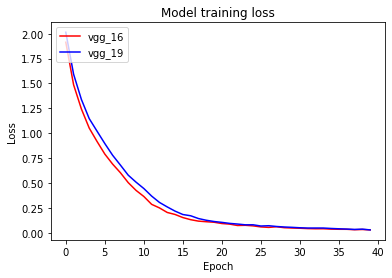

In [20]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

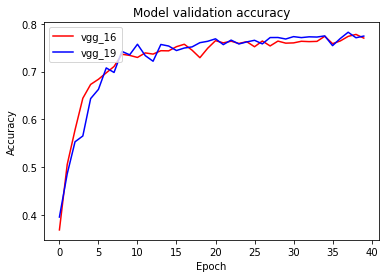

In [21]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()